# Figure 3 (Mixed Model Analysis)

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf

In [2]:
# Replace with the path to where you store data
DATA_PATH = "../../cnt-data/"

# Set up the seaborn style
sns.set_style("whitegrid")

In [3]:
def get_patient_hup_ids(directory):
    # List all files in the directory
    files = os.listdir(directory)

    # Filter out files based on the given pattern and extract patient_hup_id as integers
    patient_hup_ids = [
        int(f.split("_")[1].split(".")[0]) for f in files if f.startswith("HUP_")
    ]

    return patient_hup_ids


TABLES_PATH = os.path.join(DATA_PATH, "giant_new_tables")
completed_hup_ids = get_patient_hup_ids(TABLES_PATH)
completed_hup_ids.sort()

## Pre first seizure data only

In [13]:
def get_relevant_data(df, hours_before=12):
    # Find the first seizure time
    first_seizure_time = df[df["had_seizure"] >= 1]["emu_minute"].min()

    # # Calculate the start time for the 12-hour period before the first seizure
    # start_time = (
    #     first_seizure_time - 2 * hours_before * 30
    # )  # Since each row represents 2 minutes

    # Select the data for the period before the first seizure
    pre_seizure_data = df[
        (df["emu_minute"] >= 0) & (df["emu_minute"] < first_seizure_time - 20)
    ]

    # Return the combined data
    return pre_seizure_data


# Prepare dataframes for all patients
dfs = []
for patient_hup_id in completed_hup_ids:
    patient_features_df = pd.read_csv(
        os.path.join(TABLES_PATH, f"HUP_{str(patient_hup_id)}.csv")
    )

    # Only keep emu_minute, synchrony_broadband,med_sum_no_lorazepam_raw, and had_seizure columns
    patient_features_df = patient_features_df[
        [
            "synchrony_broadband",
            "med_sum_no_lorazepam_raw",
            "ad_ratio",
            "had_seizure",
            "emu_minute",
        ]
    ]

    # Add a column for patient_hup_id
    patient_features_df["patient_hup_id"] = patient_hup_id

    dfs.append(get_relevant_data(patient_features_df))

# Combine them into one dataframe
all_data = pd.concat(dfs).reset_index(drop=True)
# drop rows with any missing values
all_data = all_data.dropna()
# Reset the index
all_data = all_data.reset_index(drop=True)

In [14]:
# Prepare the model
model = smf.mixedlm(
    "med_sum_no_lorazepam_raw ~ synchrony_broadband + ad_ratio",
    all_data,
    groups=all_data["patient_hup_id"],
)

# Fit the model
result = model.fit()
print(result.summary())

                Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: med_sum_no_lorazepam_raw
No. Observations: 145647  Method:             REML                    
No. Groups:       66      Scale:              0.0342                  
Min. group size:  1       Log-Likelihood:     38816.9997              
Max. group size:  10081   Converged:          Yes                     
Mean group size:  2206.8                                              
-----------------------------------------------------------------------
                       Coef.   Std.Err.     z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------------
Intercept               0.496     0.028   17.958  0.000   0.442   0.550
synchrony_broadband    -0.328     0.007  -48.779  0.000  -0.341  -0.314
ad_ratio               -0.001     0.000   -8.417  0.000  -0.001  -0.001
Group Var               0.050     0.047                                



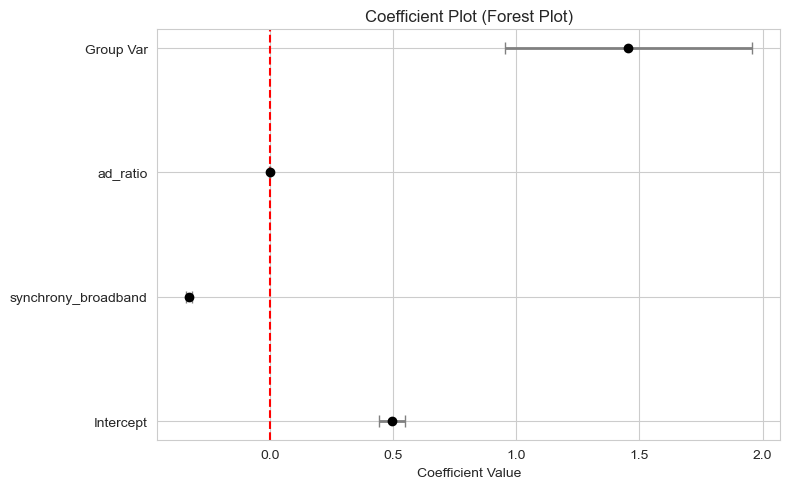

In [15]:
# Extracting the coefficients, confidence intervals, and standard errors
params = result.params
conf_int = result.conf_int()
errors = result.bse

# Coefficients and their confidence intervals
coef_names = params.index
coef_values = params.values
lower_ci = conf_int[0].values
upper_ci = conf_int[1].values

# Create the plot
fig, ax = plt.subplots(figsize=(8, 5))

# Plot the coefficients as points
ax.errorbar(
    coef_values,
    coef_names,
    xerr=[
        np.array(coef_values) - np.array(lower_ci),
        np.array(upper_ci) - np.array(coef_values),
    ],
    fmt="o",
    color="black",
    ecolor="gray",
    elinewidth=2,
    capsize=4,
)

# Add a vertical line at x=0 for reference
ax.axvline(x=0, color="red", linestyle="--")

# Labeling the plot
ax.set_xlabel("Coefficient Value")
ax.set_title("Coefficient Plot (Forest Plot)")

# Show plot
plt.tight_layout()
plt.show()

## All data

In [11]:
def get_relevant_data(df, hours_before=12):
    # Find the first seizure time
    first_seizure_time = df[df["had_seizure"] >= 1]["emu_minute"].min()

    # Find the last seizure time
    last_seizure_time = df[df["had_seizure"] >= 1]["emu_minute"].max()

    # Calculate the start time for the 12-hour period before the first seizure
    start_time = (
        first_seizure_time - 2 * hours_before * 30
    )  # Since each row represents 2 minutes

    # Select the data for the period before the first seizure
    pre_seizure_data = df[
        (df["emu_minute"] >= start_time) & (df["emu_minute"] < first_seizure_time)
    ]

    # Select the data after the last seizure
    post_seizure_data = df[df["emu_minute"] > last_seizure_time]

    # Return the combined data
    return pd.concat([pre_seizure_data, post_seizure_data])


# Prepare dataframes for all patients
dfs = []
for patient_hup_id in completed_hup_ids:
    patient_features_df = pd.read_csv(
        os.path.join(TABLES_PATH, f"HUP_{str(patient_hup_id)}.csv")
    )

    # Only keep emu_minute, synchrony_broadband,med_sum_no_lorazepam_raw, and had_seizure columns
    patient_features_df = patient_features_df[
        [
            "emu_minute",
            "synchrony_broadband",
            "med_sum_no_lorazepam_raw",
            # "had_seizure",
            "time_since_last_seizure",
            "ad_ratio",
        ]
    ]

    # Add a column for patient_hup_id
    patient_features_df["patient_hup_id"] = patient_hup_id

    # dfs.append(get_relevant_data(patient_features_df))
    dfs.append(patient_features_df)


# Combine them into one dataframe
all_data = pd.concat(dfs).reset_index(drop=True)
# drop rows with any missing values
all_data = all_data.dropna()
# Reset the index
all_data = all_data.reset_index(drop=True)

In [ ]:
# Prepare the model
model = smf.mixedlm(
    "med_sum_no_lorazepam_raw ~ synchrony_broadband + time_since_last_seizure + emu_minute + ad_ratio",
    all_data,
    groups=all_data["patient_hup_id"],
)

# Fit the model
result = model.fit()
print(result.summary())

# print the r^2 value
# print("r^2 value:", result.rsquared)

## Figure 3 (A) - Coefficients of Linear Mixed Model

In [ ]:
# Drop Group Var and Intercept from the results
coefficients = result.params.drop(["Group Var", "Intercept"]).values
predictors = result.params.drop(["Group Var", "Intercept"]).index
std_errors = result.bse.drop(["Group Var", "Intercept"]).values

# For a 95% confidence interval, z value is approximately 1.96
z_value = 1.96
conf_intervals = [
    (coef - z_value * se, coef + z_value * se)
    for coef, se in zip(coefficients, std_errors)
]

# Calculate lower and upper errors for each coefficient
lower_errors = [
    coef - ci_low for coef, (ci_low, ci_high) in zip(coefficients, conf_intervals)
]
upper_errors = [
    ci_high - coef for coef, (ci_low, ci_high) in zip(coefficients, conf_intervals)
]


# Create the coefficient plot
plt.figure(figsize=(5, 3))
for idx, (coef, predictor) in enumerate(zip(coefficients, predictors)):
    plt.errorbar(
        coef,
        idx,
        xerr=[[lower_errors[idx]], [upper_errors[idx]]],
        fmt="o",
        color="blue",
        ecolor="gray",
        elinewidth=2,
        capsize=5,
    )

# Formatting
plt.yticks(range(len(predictors)), predictors)
plt.axvline(0, color="red", linestyle="--")  # Add a vertical line for 0
plt.xlabel("Coefficient Value")
plt.ylabel("Predictors")
# plt.title("Mixed Model Coefficients with 95% Confidence Intervals")
plt.tight_layout()
plt.show()

## Figure 3 (B) - Relative Importance from Dominance Analysis

In [ ]:
# Number of bootstraps
n_boots = 1000

# List of predictors
predictors = [
    "synchrony_broadband",
    "time_since_last_seizure",
    "emu_minute",
    "ad_ratio",
]
coefficients = {pred: [] for pred in predictors}

for _ in range(n_boots):
    # Sample data with replacement
    boot_data = all_data.sample(frac=1, replace=True)

    # Fit model on bootstrap sample
    model = smf.mixedlm(
        "med_sum_no_lorazepam_raw ~ synchrony_broadband + time_since_last_seizure + emu_minute + ad_ratio",
        boot_data,
        groups=boot_data["patient_hup_id"],
    )
    result = model.fit()

    # Store coefficients
    for pred in predictors:
        coefficients[pred].append(result.params[pred])

# Calculate variability (standard deviation) of coefficients for each predictor
relative_importance = {pred: np.std(coefficients[pred]) for pred in predictors}

# Compute standard error for each predictor
standard_errors = {
    pred: std / np.sqrt(n_boots) for pred, std in relative_importance.items()
}

# Sort the predictors based on relative importance
sorted_predictors = sorted(
    relative_importance, key=relative_importance.get, reverse=True
)

# Visualization
plt.figure(figsize=(6, 3))
plt.bar(
    sorted_predictors,
    [relative_importance[pred] for pred in sorted_predictors],
    yerr=[standard_errors[pred] for pred in sorted_predictors],
    capsize=10,
)
plt.ylabel("Standard Deviation of Coefficients")
plt.title("Relative Importance of Predictors with Error Bars")
plt.xticks(rotation=45)  # Rotate predictor names for better readability
plt.show()

In [ ]:
!jupyter nbconvert --to python figure_3.ipynb